In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [16]:
data = pd.read_csv('/content/Breast_cancer_data.csv')
data.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


<Axes: >

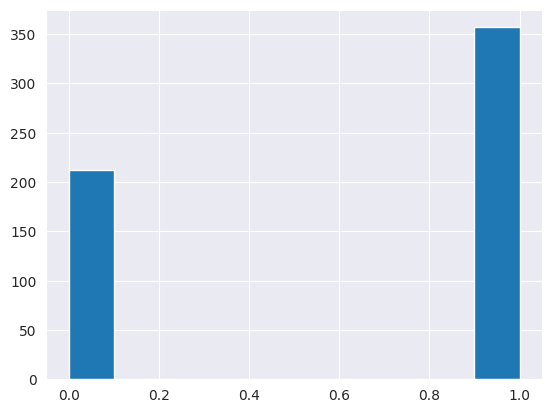

In [4]:
# EDA
data['diagnosis'].hist()

<Axes: >

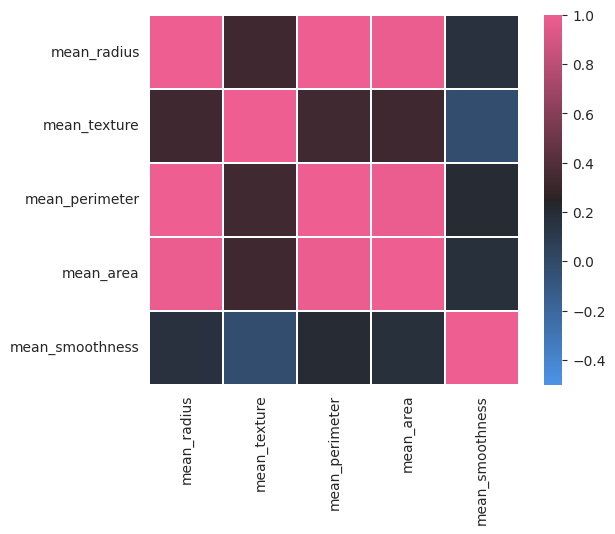

In [6]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr,vmax=1,vmin=-.5,cmap=cmap,square=True,linewidth=.2)

In [17]:
data = data[['mean_radius','mean_texture','mean_smoothness','diagnosis']]
data.head()

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0


<Axes: xlabel='mean_smoothness', ylabel='Count'>

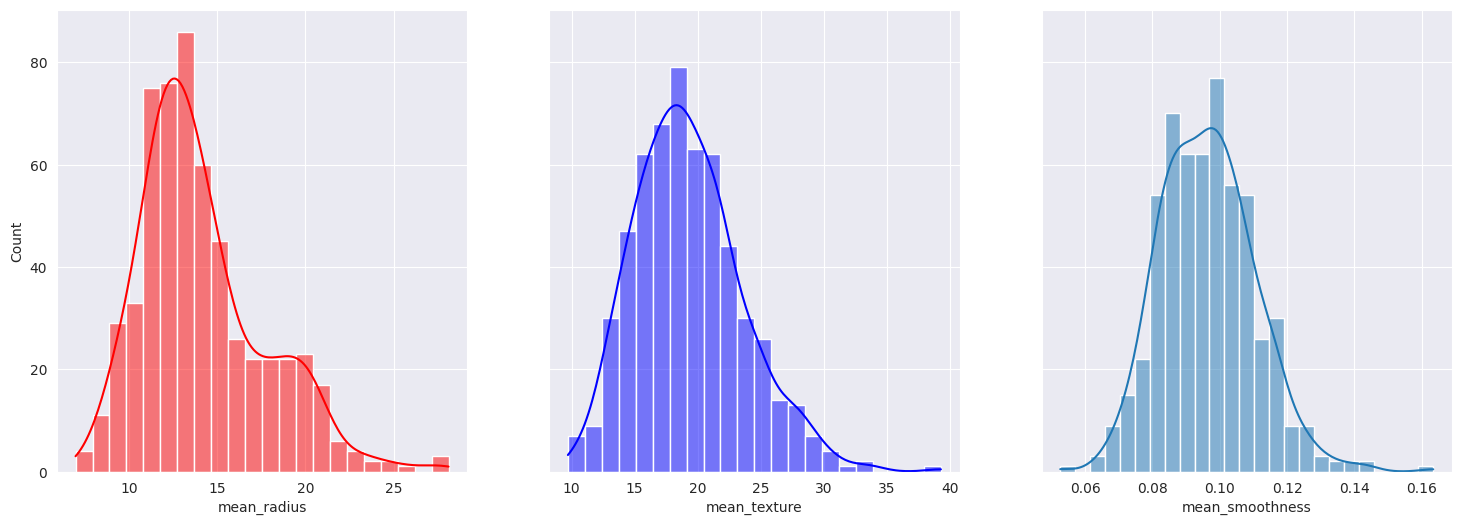

In [9]:
fig, axes = plt.subplots(1,3, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x='mean_radius', kde=True, color='r')
sns.histplot(data, ax=axes[1], x='mean_texture', kde=True, color='b')
sns.histplot(data, ax=axes[2], x='mean_smoothness', kde=True)

In [10]:
def calculate_prior(df, y):
  classes = sorted(list(df[y].unique()))
  prior = []
  for i in classes:
    prior.append(len(df[df[y] == i])/len(y))
  return prior

In [11]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, y, label):
  feat = list(df.columns)
  df = df[df[y] == label]
  mean, std = df[feat_name].mean(), df[feat_name].std()
  p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-((feat_val - mean)**2)/ (2 * std**2))
  return p_x_given_y

In [12]:
def naive_bayes_gaussian(df, X, y):
  features = list(df.columns)[:-1]
  prior = calculate_prior(df, y)
  y_pred = []
  for x in X:
    labels = sorted(list(df[y].unique()))
    likelihood = [1]*len(labels)
    for j in range(len(labels)):
      for i in range(len(features)):
        likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], y, labels[j])

    post_prob = [1] * len(labels)
    for j in range(len(labels)):
      post_prob[j] = likelihood[j] * prior[j]

    y_pred.append(np.argmax(post_prob))
  return np.array(y_pred)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

train, test = train_test_split(data, test_size=0.2, random_state=42)
X_test = test.iloc[:,:-1].values
y_test = test.iloc[:,-1].values
y_pred = naive_bayes_gaussian(train, X_test, 'diagnosis')
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred))

[[39  4]
 [ 2 69]]
0.9583333333333334


In [18]:
# Another approach: converting continuous variable to categorical features
data['cat_mean_radius'] = pd.cut(data['mean_radius'], bins=3, labels=[0,1,2])
data['cat_mean_texture'] = pd.cut(data['mean_texture'], bins=3, labels=[0,1,2])
data['cat_mean_smoothness'] = pd.cut(data['mean_smoothness'], bins=3, labels=[0,1,2])
data = data[['cat_mean_radius','cat_mean_texture','cat_mean_smoothness', 'diagnosis']]
data.head()

,cat_mean_radius,cat_mean_texture,cat_mean_smoothness,diagnosis
0,1,0,1,0
1,1,0,0,0
2,1,1,1,0
3,0,1,2,0
4,1,0,1,0


In [19]:
def calculate_likelihood_categorical(df, feat_name, feat_val, y, label):
  feat = list(df.columns)
  df = df[df[y] == label]
  p_x_given_y = len(df[df[feat_name] == feat_val]) / len(df)
  return p_x_given_y

In [20]:
def naive_bayes_categorical(df, X, y):
  features = list(df.columns)[:-1]
  prior = calculate_prior(df, y)
  y_pred = []
  for x in X:
    labels = sorted(list(df[y].unique()))
    likelihood = [1]*len(labels)
    for j in range(len(labels)):
      for i in range(len(features)):
        likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], y, labels[j])

    post_prob = [1] * len(labels)
    for j in range(len(labels)):
      post_prob[j] = likelihood[j] * prior[j]

    y_pred.append(np.argmax(post_prob))
  return np.array(y_pred)

In [22]:
train, test = train_test_split(data, test_size=0.2, random_state=42)
X_test = test.iloc[:,:-1].values
y_test = test.iloc[:,-1].values
y_pred = naive_bayes_categorical(train, X_test, 'diagnosis')
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred))

[[37  6]
 [ 7 64]]
0.9078014184397163
